In [251]:
%load_ext autoreload
%autoreload 2
import sys
import pickle
from pathlib import Path
gpu_implementation_path = '/home/mt/repos/research.mtne/gpu_implementation'
if gpu_implementation_path not in sys.path:
    sys.path.append(gpu_implementation_path)
gpu_implementation_analysis_path = '/home/mt/repos/research.mtne/gpu_implementation/analysis'
if gpu_implementation_analysis_path not in sys.path:
    sys.path.append(gpu_implementation_analysis_path)
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import utils
from metrics import *

# from esmt import TrainingState

main_log_dir = Path(gpu_implementation_path) / "logs"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
experiments = {
    'ST-zaxxon': {'dir': main_log_dir / 'ST-zaxxon-5000', 'type': 'ST'},
    'ST-riverraid': {'dir': main_log_dir / 'ST-riverraid-5000', 'type': 'ST'},
    'MT': {'dir': main_log_dir / 'MT-zaxxon-riverraid-5000', 'type': 'MT' },
    'ST-riverraid-zaxxon': {'dir': main_log_dir / 'evaluate_riverraid_using_zaxxon_model', 'type': 'ST'},
    'ST-zaxxon-riverraid': {'dir': main_log_dir / 'evaluate_zaxxon_using_riverraid_model', 'type': 'ST'}    
}

In [253]:
for exp_name, exp in experiments.items():
    exp['cfg'] = utils.get_config(exp)
    exp['rewards'] = utils.get_rewards(exp)

/home/mt/repos/research.mtne/gpu_implementation/logs/ST-zaxxon-5000
/home/mt/repos/research.mtne/gpu_implementation/logs/evaluate_zaxxon_using_riverraid_model
/home/mt/repos/research.mtne/gpu_implementation/logs/MT-zaxxon-riverraid-5000
/home/mt/repos/research.mtne/gpu_implementation/logs/evaluate_riverraid_using_zaxxon_model
/home/mt/repos/research.mtne/gpu_implementation/logs/ST-riverraid-5000


In [254]:
iterations = 200

[(0, 200)]

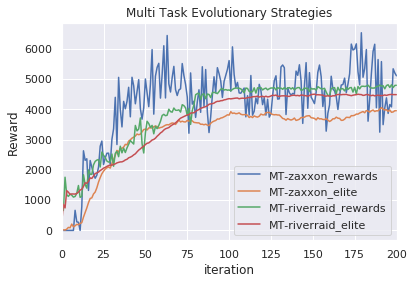

In [255]:
# 1) MTES rewards (both offspring and elite)
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
p = experiments['MT']['rewards'].plot()
p.set_title('Multi Task Evolutionary Strategies')
p.set_ylabel('Reward')
p.set(xlim=(0, iterations))

[(0, 200)]

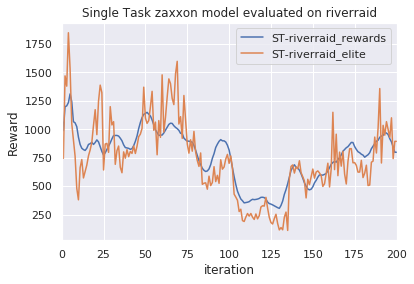

In [256]:
# 2) STES rewards (both offspring and elite) [zaxxon evaluated on riverraid]
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
p = experiments['ST-riverraid-zaxxon']['rewards'].plot()
p.set_title('Single Task zaxxon model evaluated on riverraid')
p.set_ylabel('Reward')
p.set(xlim=(0, iterations))

[(0, 200)]

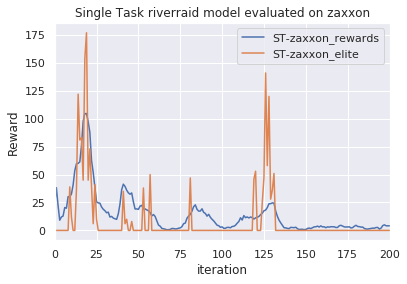

In [257]:
# 3) Same as 2, but STES [riverraid evaluated on zaxxon]
p = experiments['ST-zaxxon-riverraid']['rewards'].plot()
p.set_title('Single Task riverraid model evaluated on zaxxon')
p.set_ylabel('Reward')
p.set(xlim=(0, iterations))

Text(0, 0.5, 'Hypervolume')

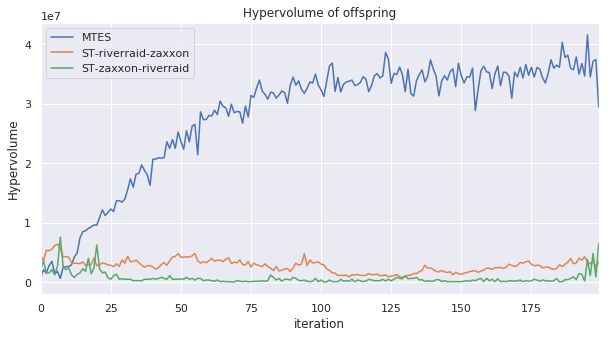

In [258]:
# 4) hypervolume (offspring only)
# x axis: iterations (0 to 200)
# y axis: hypervolume
# lines: (a) MTES; (b) STES [zaxxon evaluated on riverraid]; (c) STES [riverraid evaluated on zaxxon].
hv_df = pd.DataFrame.from_dict({
    'MTES': utils.get_hypervolume_data(experiments['MT'], iterations)['pareto'],
    'ST-riverraid-zaxxon': utils.get_hypervolume_data(experiments['ST-riverraid-zaxxon'], iterations)['pareto'],
    'ST-zaxxon-riverraid': utils.get_hypervolume_data(experiments['ST-zaxxon-riverraid'], iterations)['pareto']
})
sns.set(rc={'figure.figsize': (10, 5)})
hv_df['iteration'] = range(0, iterations)
hv_df.set_index('iteration')
del hv_df['iteration']
p = hv_df.plot()
p.set_title('Hypervolume of offspring')
p.set_ylabel('Hypervolume')

Text(0, 0.5, 'DKL')

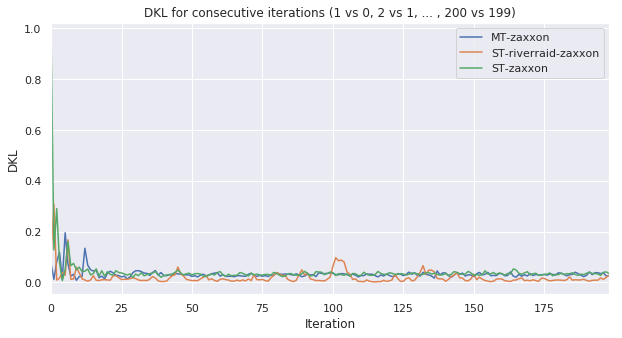

In [259]:
# 5) DKL (offspring only) – 2 plots: one for task 0, one for task 1
# x axis: iterations (0 to 200)
# y axis: DKL for consecutive iterations (1 vs 0, 2 vs 1, 3 vs 2, ... , 200 vs 199)
# lines: (a) MTES; (b) STES [zaxxon evaluated on riverraid]; (c) STES [riverraid evaluated on zaxxon].

bin_size = 100
epsilon = 0.0001
dkl0 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon) for i in range(1, iterations)],
    'ST-zaxxon': [utils.compute_dkl(experiments['ST-zaxxon'], 0, i, bin_size, epsilon) for i in range(1, iterations)],
    'ST-riverraid-zaxxon': [utils.compute_dkl(experiments['ST-riverraid-zaxxon'], 0, i, bin_size, epsilon) for i in range(1, iterations)]
})
p = dkl0.plot()
p.set_title("DKL for consecutive iterations (1 vs 0, 2 vs 1, ... , 200 vs 199)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL")

Text(0, 0.5, 'DKL')

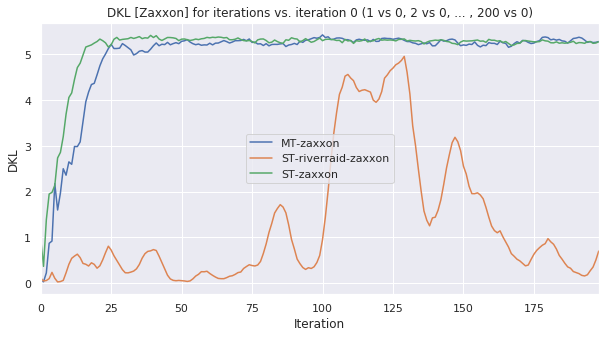

In [263]:
# 6) same as 5), but y axis is “DKL for iterations (1 vs 0, 2 vs 0, 3 vs 0, ... , 200 vs 0)” (note: also in this case we need 2 plots: one for task 0, one for tasak 1)
dkl_from0_0 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)],
    'ST-zaxxon': [utils.compute_dkl(experiments['ST-zaxxon'], 0, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)],
    'ST-riverraid-zaxxon': [utils.compute_dkl(experiments['ST-riverraid-zaxxon'], 0, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)]
})
p = dkl_from0_0.plot()
p.set_title("DKL [Zaxxon] for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL")

Text(0, 0.5, 'DKL')

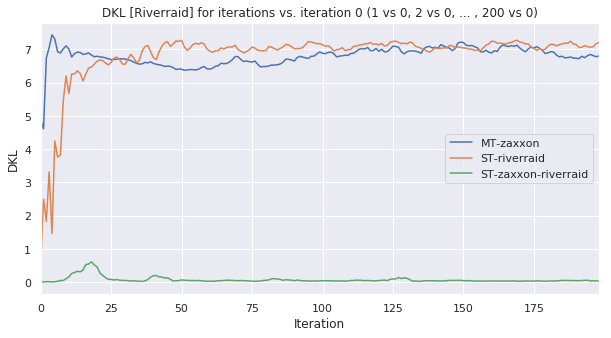

In [264]:
dkl_from0_1 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)],
    'ST-riverraid': [utils.compute_dkl(experiments['ST-riverraid'], 0, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)],
    'ST-zaxxon-riverraid': [utils.compute_dkl(experiments['ST-zaxxon-riverraid'], 0, i, bin_size, epsilon, from_0=True) for i in range(1, iterations)]
})
p = dkl_from0_1.plot()
p.set_title("DKL [Riverraid] for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL")

Text(0, 0.5, 'DKL')

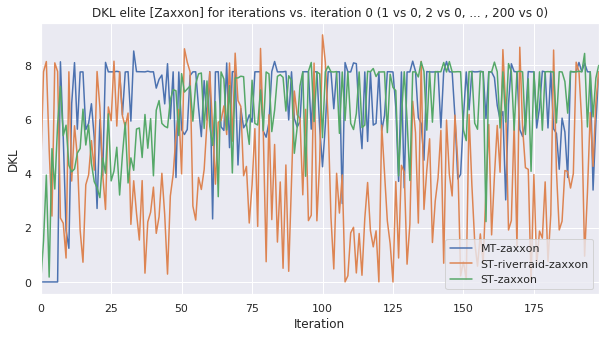

In [266]:
# 7) - same as 5) but elite only
dkl_elite_0 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, elite_or_rewards='elite') for i in range(1, iterations)],
    'ST-zaxxon': [utils.compute_dkl(experiments['ST-zaxxon'], 0, i, bin_size, epsilon, elite_or_rewards='elite') for i in range(1, iterations)],
    'ST-riverraid-zaxxon': [utils.compute_dkl(experiments['ST-riverraid-zaxxon'], 0, i, bin_size, epsilon, elite_or_rewards='elite') for i in range(1, iterations)]
})
p = dkl_elite_0.plot()
p.set_title("DKL elite [Zaxxon] for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL")

Text(0, 0.5, 'DKL')

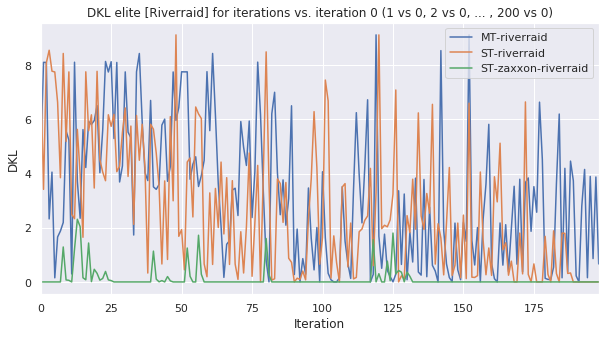

In [268]:
dkl_elite_1 = pd.DataFrame.from_dict({
    'MT-riverraid': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, elite_or_rewards='elite') for i in range(1, iterations)],
    'ST-riverraid': [utils.compute_dkl(experiments['ST-riverraid'], 0, i, bin_size, epsilon, elite_or_rewards='elite') for i in range(1, iterations)],
    'ST-zaxxon-riverraid': [utils.compute_dkl(experiments['ST-zaxxon-riverraid'], 0, i, bin_size, epsilon, elite_or_rewards='elite') for i in range(1, iterations)]
})
p = dkl_elite_1.plot()
p.set_title("DKL elite [Riverraid] for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL")

Text(0, 0.5, 'DKL')

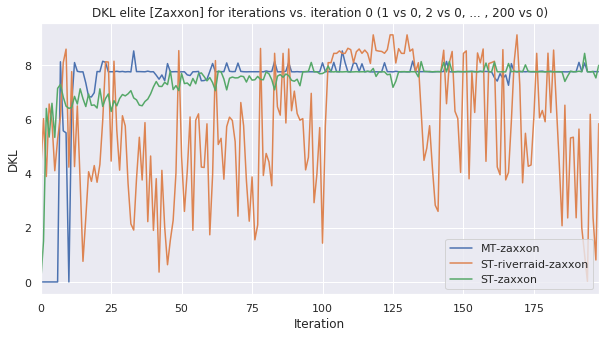

In [269]:
# 8) same as 6) but elite
dkl_from0_elite_0 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, elite_or_rewards='elite', from_0=True) for i in range(1, iterations)],
    'ST-zaxxon': [utils.compute_dkl(experiments['ST-zaxxon'], 0, i, bin_size, epsilon, elite_or_rewards='elite', from_0=True) for i in range(1, iterations)],
    'ST-riverraid-zaxxon': [utils.compute_dkl(experiments['ST-riverraid-zaxxon'], 0, i, bin_size, epsilon, elite_or_rewards='elite', from_0=True) for i in range(1, iterations)]
})
p = dkl_from0_elite_0.plot()
p.set_title("DKL elite [Zaxxon] for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL")


Text(0, 0.5, 'DKL')

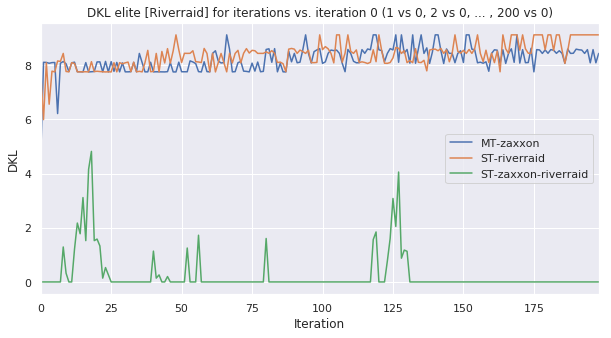

In [270]:
dkl_from0_elite_1 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, elite_or_rewards='elite', from_0=True) for i in range(1, iterations)],
    'ST-riverraid': [utils.compute_dkl(experiments['ST-riverraid'], 0, i, bin_size, epsilon, elite_or_rewards='elite', from_0=True) for i in range(1, iterations)],
    'ST-zaxxon-riverraid': [utils.compute_dkl(experiments['ST-zaxxon-riverraid'], 0, i, bin_size, epsilon, elite_or_rewards='elite', from_0=True) for i in range(1, iterations)]
})
p = dkl_from0_elite_1.plot()
p.set_title("DKL elite [Riverraid] for iterations vs. iteration 0 (1 vs 0, 2 vs 0, ... , 200 vs 0)")
p.set_xlabel("Iteration")
p.set_ylabel("DKL")
